# Machine Learning flow rule - Work Hardening

Machine Learning (ML) algorithms provide a great flexibility to describe aribitrary mathematical functions. At the same time they offer the possibility to handle large data sets and multi-dimensional features as input. Hence, using ML algorithms as constitutive rules for plastic material behavior offers the possibility to explicitly take into account microstructural information of the material in the constitutive modeling. Furthermore, data resulting from experiment and micromechanical simulations can be hybridized to generate training data sets. The present example is using Support Vector Classification (SVC) as yield function. The SVC algorithm is trained by using deviatoric stresses as input data and the information whether a given stress state leads to purely elastic or rather to elastic-plastic deformation of the material as result data. In this way, a ML yield function is obtained, which can determine whether a given stress state lies inside or outside of the elastic regime of the material. Furthermore, the yield locus, i.e., the hyperplane in stress space on which plastic deformation occurs, can be reconstructed from the SVC, and the gradient on this yield locus can be conveniently calculated. Therefore, the standard formulations of continuum plasticity, as the return mapping algorithm, can be applied in Finite Element Analysis (FEA) in the usual way. Thus, it is demonstrated that the new ML yield function can replace conventional FEA yield functions. In a next step, microstructural information will be considered directly as feature. Machine learning algorithms have been adopted from the scikit-learn platform (https://scikit-learn.org/stable/). 

This notebook demonstrates the training and application of ML flow rules in FEA in form of a simple example with data synthetically produced fromisotropic J2 (von Mises) plasticity with isotropic work hardening. For details of Machine Learning (ML) flow rules see the article by A. Hartmaier "Data-Oriented Constitutive Modeling of Plasticity in Metals" Materials 2020, 13(7), 1600. This open access article is available <a rel="preprint" href="https://www.mdpi.com/1996-1944/13/7/1600#">here</a>. Furthermore, it is shown, how data from micromechanical simulations can be used as basis for training of ML flow rules. This notebook uses the pyLabFEA package, the matplotlib (https://matplotlib.org/) library for the visualization of results, and NumPy (http://www.numpy.org) for mathematical operations with arrays.

Author: Alexander Hartmaier, ICAMS, Ruhr-Universtität Bochum, Germany, April 2020

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 


## Theoretical background
The yield function of a material is defined as 
\begin{equation} f = \sigma_{eq} - \sigma_y\,, \end{equation}
where plastic deformation sets in at $f=0$, i.e. when the the equivalent stress $\sigma_{eq}$ equals the yield strength $\sigma_y$ of the material. The equivalent stress used here is based on the pricipal stresses $\sigma_i$ with $(i=1, 2, 3)$, as

\begin{equation} 
\sigma^\mathrm{J2}_{eq} = \sqrt{ \frac{1}{2}\left[ H_1 \left(\sigma_1-\sigma_2\right)^2 
                       + H_2 \left(\sigma_2-\sigma_3\right)^2 
                       + H_3 \left(\sigma_3-\sigma_1\right)^2   \right] } .
\end{equation}

In this yield function, the anisotropy of the material's flow behavior is described in a Hill-like approach for orthotropic materials. If the axes of the pricipal stresses do not match the symmetry axes of the material, the material axes and with it the parameters $H_1, H_2$ and $H_3$ must be rotated into the coordinate system of the eigenvectors of the stress tensor. 

The gradient of the yield function with respect to the pricipal stresses is needed for calculating the plastic strain increments in the return mapping algorithm of continuum plasticity, and can be evaluated analytically as
\begin{equation}
\frac{\partial f}{\partial \sigma_1} = \frac{\partial \sigma_{eq}}{\partial \sigma_1} = \frac{\left( H_1+H_3 \right) \sigma_1 - H_1 \sigma_2 - H_3 \sigma_3}{\sigma_{eq}}  \\
\frac{\partial f}{\partial \sigma_2} = \frac{\partial \sigma_{eq}}{\partial \sigma_2} = \frac{\left( H_2+H_1 \right) \sigma_2 - H_1 \sigma_1 - H_2 \sigma_3}{\sigma_{eq}}  \\
\frac{\partial f}{\partial \sigma_3} = \frac{\partial \sigma_{eq}}{\partial \sigma_3} = \frac{\left( H_3+H_2 \right) \sigma_3 - H_3 \sigma_1 - H_2 \sigma_2}{\sigma_{eq}}  \\
\end{equation}

Note that in the case of isotropic plasticity, i.e. $H_1=H_2=H_3=1$, the gradient takes the simple form
\begin{equation}
\frac{\partial f}{\partial \sigma_i} = 3 \frac{\sigma_i - p}{\sigma_{eq}} \hspace{2em} (i=1,2,3) ,
\end{equation}
where $p = 1/3 \mbox{Tr}(\sigma)$.

## Deviatoric stress space
Since plastic deformation in most metals does not depend on hydrostatic stress components, it is useful to transform the principal stresses from the representation as Cartesian (3D) vector $\sigma=(\sigma_1, \sigma_2, \sigma_3)$ in the principal stress space into a vector $s=(\sigma_{eq}, \theta, p)$ in the cylindrical coordinate system, with the equivalent stress $\sigma_{eq}$ representing the norm of the deviator of $\sigma$ and the polar angle $\theta$ lying in the deviatoric stress plane normal to the hydrostatic axis $p$. This coordinate transformation improves the efficiency of the training, because only 2D data for the equivalent stress and the polar angle $\theta$ need to be used as training features, whereas the hydrostatic component is disregarded.  The coordinate transformation is performed by introducing a complex-valued deviatoric stress
\begin{equation}
\sigma'_c = \pmb{\sigma}\cdot \pmb{a} + i\,\pmb{\sigma}\cdot \pmb{b} = \sqrt{2/3}\sigma_{eq}\; e^{i\theta}, 
\end{equation}
where $i$ is the imaginary unit, such that the polar angle is obtained as
\begin{equation}
\theta = \mathrm{arg}\, \sigma'_c = -i \, \ln \frac{\pmb{\sigma}\cdot \pmb{a} + 
         i\,\pmb{\sigma}\cdot \pmb{b}}
         {\sqrt{2/3}\sigma_{eq}} \,,
\end{equation}

where $a=(2,-1,-1)/\sqrt{6}$ (real axis) and $b=(0,1,-1)/\sqrt{2}$ (imaginary axis) are the unit vectors that span the deviatoric stress plane normal to the hydrostatic axis $c=(1,1,1)/\sqrt{3}$.

An advantage of this coordinate transformation is that the gradient of the yield function w.r.t. the cylindrical coordinates has only one non-constant component. The complete gradient w.r.t. the cylindrical coordinates reads
\begin{eqnarray*}
\frac{\partial f}{\partial \sigma_{eq}} &=& 1 \\
\frac{\partial f}{\partial \theta} &=& \frac{\partial \sigma_y}{\partial \theta} \\
\frac{\partial f}{\partial p} &=& 0 .
\end{eqnarray*}

To transform the gradient of the flow rule from this cylindrical coordinate system back to the principle stress space, in which form it is used later on to calculate the direction of the plastic strain increments in the return mapping algorithm of the plasticity model, we introduce the Jacobian matrix for this coordinate transformation as 
\begin{equation}
J=\frac{\partial s}{\partial \sigma} = \left(
\begin{array}{ccc}
\frac{\partial \sigma_{eq}}{\partial \sigma_1} & \frac{\partial \theta}{\partial \sigma_1} & 
\frac{\partial p}{\partial \sigma_1} \\
\frac{\partial \sigma_{eq}}{\partial \sigma_2} & \frac{\partial \theta}{\partial \sigma_2} & 
\frac{\partial p}{\partial \sigma_2} \\
\frac{\partial \sigma_{eq}}{\partial \sigma_3} & \frac{\partial \theta}{\partial \sigma_3} & 
\frac{\partial p}{\partial \sigma_3} \\
\end{array}
\right)
\end{equation}
with ${\partial \sigma_{eq}}/{\partial \sigma_i}$ as given above, ${\partial p}/{\partial \sigma_i}=1/3$, and
\begin{equation}
\frac{\partial \theta}{\partial \sigma_j} = -i\, \left( 
        \frac{\pmb{a} + i\,\pmb{b}}{\pmb{\sigma}\cdot \pmb{a} + i\,\pmb{\sigma}\cdot \pmb{b}} -
        \frac{3\, \pmb{\sigma}'}{\sigma_{eq}^2} \right)    \hspace{2em} (j=1,2,3) . 
\end{equation}
Finally, the gradient in the 3D principle stress space is obtained as
\begin{equation}
\frac{\partial f}{\partial \sigma_j} = \sum\limits_{k=1}^{3} J_{jk} 
\frac{\partial f}{\partial s_k} \hspace{2em} (j=1,2,3) .
\end{equation}

## Material definition
In the following, the Python class `Material` is invoked to be used as a material card in FEA, demonstrating the application of standard flow rules and machine learning (ML) flow rules. This class `Material` contains the attributes and methods to defining the elastic and plastic material behavior and to evaluate the materials constitutive behavior. Furthermore, all necessary subroutines for plotting the results are defined.
Two identical materials are defined,`mat_h` will be used to apply the standard Hill-like flow rules in FEA and to generate synthetical data that is used to train a ML flow rule in `mat_ml`. Consequently,`mat_h` and `mat_ml` should reveal identical properties, which is verified in simple FEA demonstrations for 2D plane stress cases. As reference, a further material with the same yield strength, but isotropic J2 plasticity is defined as `mat_iso`. Here, we consider ideal plasticity, i.e. no work hardening, and no dependence on the hydrostatic stress.
        

In [1]:
import pylabfea as FE
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sklearn.metrics import r2_score

'define two elastic-plastic materials with identical yield strength and elastic properties'
E=200.e3
nu=0.3
sy = 150.
kh = 0.
'reference material'
mat_j2 = FE.Material(name='Reference')
mat_j2.elasticity(E=E, nu=nu)
mat_j2.plasticity(sy=sy, khard=kh)
'isotropic material for ML flow rule'
mat_ml = FE.Material(name='ML flow rule')
mat_ml.elasticity(E=E, nu=nu)
mat_ml.plasticity(sy=sy, khard=kh)

### Create reference stress strain curves

The mechanical behavior of the reference material in chracterized by FEA, invoking the pyLabFEM module. Four load cases are simulated: (i) uniaxial stress in x-direction, (ii) uniaxial stress in y-direction, (iii) equibiaxial tensile strain under plane stress, and (iv) pure x-y-shear strain.

---------------------------------------------------------
J2 yield stress under uniax-x loading: 150.0 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 150.0 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 150.0 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 150.0 MPa
---------------------------------------------------------


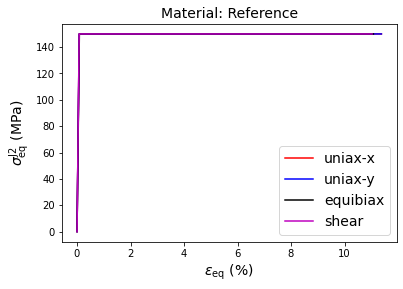

Yield loci of anisotropic reference material and isotropic material


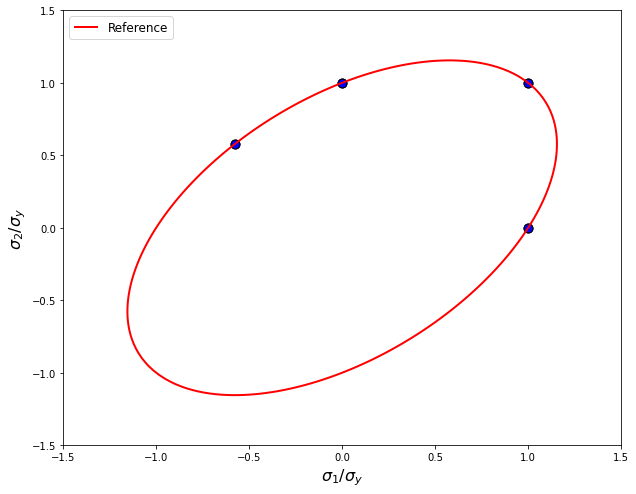

In [2]:
'Calculate and plot stress strain curves of reference material under various load cases'
mat_j2.calc_properties(eps=0.1, sigeps=True)#, min_step=3)
mat_j2.plot_stress_strain()  #file='sigHill-eps-ref'
print('Yield loci of anisotropic reference material and isotropic material')
ax = mat_j2.plot_yield_locus(xstart=-1.5, xend=1.5)  #file='yield-locus-ref'
'flow stresses'
s=80
stx = mat_j2.sigeps['stx']['sig'][:,0:2]/mat_j2.sy
sty = mat_j2.sigeps['sty']['sig'][:,0:2]/mat_j2.sy
et2 = mat_j2.sigeps['et2']['sig'][:,0:2]/mat_j2.sy
ect = mat_j2.sigeps['ect']['sig'][:,0:2]/mat_j2.sy
ax.scatter(stx[1:,0],stx[1:,1],s=s, c='#0000ff', edgecolors='k')
ax.scatter(sty[1:,0],sty[1:,1],s=s, c='#0000ff', edgecolors='k')
ax.scatter(et2[1:,0],et2[1:,1],s=s, c='#0000ff', edgecolors='k')
ax.scatter(ect[1:,0],ect[1:,1],s=s, c='#0000ff', edgecolors='k')

## Setup ML constitutive models

Here, the reference material `mat_h` with Hill-type anisotropy is used to produce training and test data for the machine learning algorithm. The yield function is represented as a step function such that Support Vector Classification (SVC) is used. In the FEA all stresses are considered in form of principal stress vectors, such that a coordinate transformation into the cylindrical coordinate system with equivalent stress and polar angle $\theta$ takes place within the training and evaluation procedure. Furthermore, to make the training process efficient, stress data for training and testing are already produced as purely deviatoric stress components, following the cylidrical stress vector definition given above. 

As one cannot assume the Hill-coefficients as know for the ML material, the standard J2 equivalent stresses for isotropic materials must be used in the analysis. In consequence, the yield stress must depend on the angle $\theta$ in order to discribe the anisotropy on the flow behavior. Thus, the yield function takes the form
\begin{equation}
f = \sigma_{eq} - \sigma_y(\theta),
\end{equation}
in which the dependencies on isotropic J2 equivalent stress $\sigma_{eq}$ and angle $\theta$ are separated.

### Train ML yield function
In the following code segment, training and test data are generated and applied for training of the SVC, and the quality test of the result. For the data and the trained ML yield function are plotted in the cylindrical stress space.

Plot theta vs. Hill eqiv. stress curves for reference material with known anisotropic coefficients


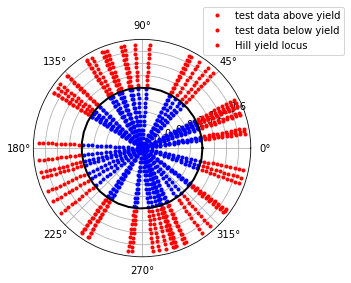


-------------------------

SVM classification fitted
-------------------------

Using priciples stresses for training
SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Training data points (only polar angle): 600 , Test data points: 60
Training set score: 100.0 %
Test set score: 100.0 %
r^2 on test data : 1.000000
Number of support vectors generated:  1634
Plot theta vs. J2 eqiv. stress curves for ML material


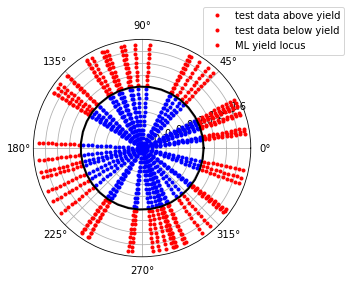

Plot of yield locus and training data in slices of 3D principle stress space
Plot of trained SVM classification with test data in 2D cylindrical stress space


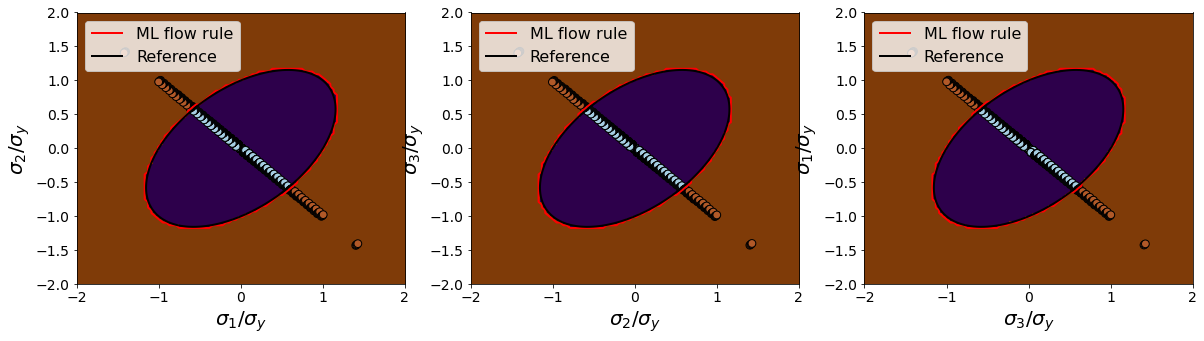

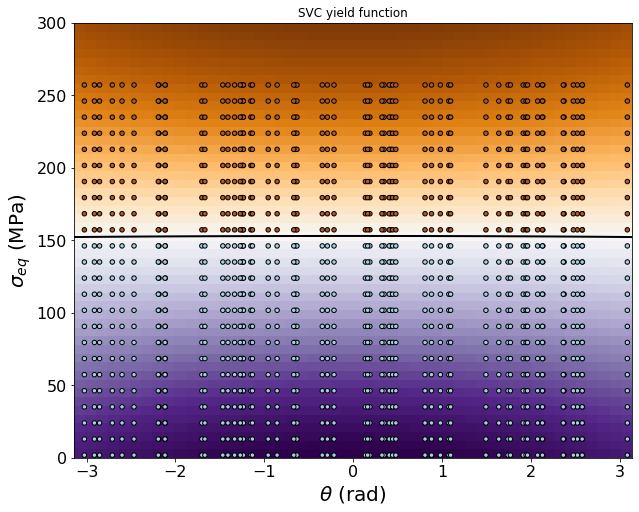

In [3]:
'Create training data in deviatoric stress space for components seq and theta'
def create_data(N, mat, extend=False, rand=False):
    # create stresses along unit circle normal to hydrostatic axis
    if not rand:
        theta = np.linspace(-np.pi, np.pi, N)
    else:
        theta = 2.*(np.random.rand(N)-0.5)*np.pi
    sig = FE.sp_cart(np.array([np.ones(N)*np.sqrt(3/2), theta]).T)
    offs = 0.01
    x = offs*sig
    N = 23
    for i in range(N):
        hh = offs + (1.4-offs)*(i+1)/N
        x = np.append(x, hh*sig, axis=0)
    if extend:
        # add training points in plastic regime to avoid fallback of SVC decision fct. to zero
        for i in range(10):
            x = np.append(x, (i+2)*sig, axis=0)
    'result data for ML yield function (only sign is considered)'
    y = np.sign(mat.calc_yf(x*mat.sy, ana=True))
    return x,y 

'Training and testing data for ML yield function, based on reference Material mat_J2'
ndata = 600
ntest = np.maximum(20, int(ndata/10))
x_train, y_train = create_data(ndata, mat_j2, extend=True) 
x_test, y_test = create_data(ntest, mat_j2, rand=True)
x_train *= mat_j2.sy
x_test *= mat_j2.sy

print('Plot theta vs. Hill eqiv. stress curves for reference material with known anisotropic coefficients')
ind1 = np.nonzero(y_test<0.)
ind2 = np.nonzero(y_test>=0.)
sc = FE.s_cyl(x_test, mat_j2)  # convert princ. stresses into cylidrical coordinates
plt.polar(sc[ind2,1],sc[ind2,0]/mat_j2.sy,'.r')
plt.polar(sc[ind1,1],sc[ind1,0]/mat_j2.sy,'.b')
plt.polar(np.linspace(0.,2*np.pi,36), np.ones(36), '-k', linewidth=2)
plt.legend(['test data above yield','test data below yield','Hill yield locus'], loc=(0.78,0.93))
#plt.savefig('polar-Hill.pdf', format='pdf', dpi=300)
plt.show()

'initialize and train SVC as ML yield function'
'implement ML flow rule into mat_ml'
print('\n-------------------------\n')
print('SVM classification fitted')
print('-------------------------\n')
train_sc, test_sc = mat_ml.setup_yf_SVM(x_train, y_train, x_test=x_test, y_test=y_test, 
                                      C=0.5, gamma=0.2, fs=0.3, plot=False)  
y_pred_clf = mat_ml.calc_yf(x_test,pred=True)
r2_score_svm = r2_score(y_test, y_pred_clf)
print(mat_ml.svm_yf)
print("Training data points (only polar angle):", ndata,", Test data points:", ntest)
print("Training set score: {} %".format(train_sc))
print("Test set score: {} %".format(test_sc))
print("r^2 on test data : %f" % r2_score_svm)
print("Number of support vectors generated: ",len(mat_ml.svm_yf.support_vectors_))

print('Plot theta vs. J2 eqiv. stress curves for ML material')
ind1 = np.nonzero(y_test<0.)
ind2 = np.nonzero(y_test>=0.)
sc = FE.s_cyl(x_test) # convert princ. stresses into cylindrical coordinates
plt.polar(sc[ind2,1],sc[ind2,0]/mat_ml.sy,'.r')
plt.polar(sc[ind1,1],sc[ind1,0]/mat_ml.sy,'.b')
'find norm of princ. stess vector lying on yield surface'
theta = np.linspace(0.,2*np.pi,36)
snorm = FE.sp_cart(np.array([mat_ml.sy*np.ones(36)*np.sqrt(3/2), theta]).T)
x1 = fsolve(mat_ml.find_yloc, np.ones(36), args=snorm, xtol=1.e-5)
sig = snorm*np.array([x1,x1,x1]).T
s_yld = mat_ml.calc_seq(sig)
plt.polar(theta, s_yld/mat_ml.sy, '-k', linewidth=2)
plt.legend(['test data above yield','test data below yield','ML yield locus'], loc=(0.78,0.93))
#plt.savefig('polar-J2.pdf', format='pdf', dpi=300)
plt.show()

print('Plot of yield locus and training data in slices of 3D principle stress space')
mat_ml.plot_yield_locus(field=True, data=x_train, ref_mat=mat_j2, trange=3.e-2, 
                      axis1=[0,1,2], axis2=[1,2,0]) #Nmesh=300,file='yield-fct-slices'

print('Plot of trained SVM classification with test data in 2D cylindrical stress space')
xx, yy = np.meshgrid(np.linspace(-1, 1, 50),np.linspace(-1, 1, 50))
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
feat = np.c_[yy.ravel(),xx.ravel()]
#Z = mat_ml.svm_yf.predict(feat)
Z = mat_ml.svm_yf.decision_function(feat)
hl = mat_ml.plot_data(Z, ax, xx*np.pi, (yy+1.)*mat_ml.sy, c='black')
sc = FE.s_cyl(x_test)
h1 = ax.scatter(sc[:,1], sc[:,0], s=20, c=y_test, cmap=plt.cm.Paired, edgecolors='k')
ax.set_title('SVC yield function')
ax.set_xlabel(r'$\theta$ (rad)', fontsize=20)
ax.set_ylabel(r'$\sigma_{eq}$ (MPa)', fontsize=20)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
#fig.savefig('SVM-yield-fct.pdf', format='pdf', dpi=300)

### Apply trained ML flow rule in FEA

After the successful training of the ML yield function, it can be applied directly in FEA. Its gradients of can be calculated directly from the coefficients and the support vectors resulting from the training process. The following code segment, demonstrates the application of the ML yield function in the pyLabFEA module. FEA is performed on the same four load cases under which the reference material has been characterized and the results are compared.



====== Stress-Strain-Curves ======
*** ideal ML plasticity ***
---------------------------------------------------------
J2 yield stress under uniax-x loading: 153.029 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 152.727 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 152.958 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 152.535 MPa
---------------------------------------------------------


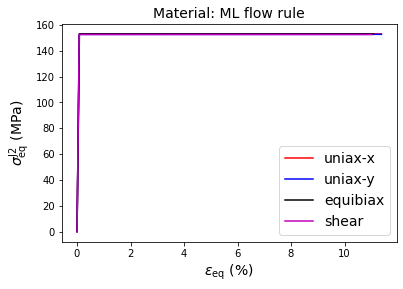


Plot evolution of stresses during plastic deformation for both materials
Hill-material: blue color
ML-material: yellow color


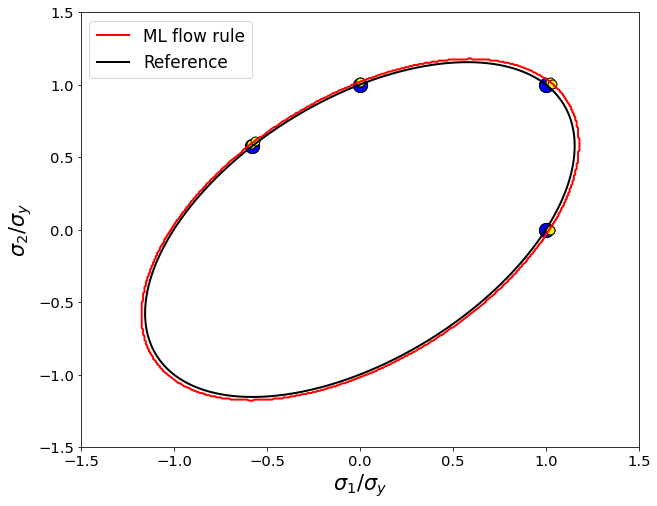

In [4]:
print('\n\n====== Stress-Strain-Curves ======')
print('*** ideal ML plasticity ***')
mat_ml.calc_properties(verb=False, eps=0.1, sigeps=True)#, min_step=8)
mat_ml.plot_stress_strain() #file='sigJ2-eps-ML')

'plot yield locus'
ax = mat_ml.plot_yield_locus(xstart=-1.5, xend=1.5, ref_mat=mat_j2, field=False, Nmesh=400, fontsize=26)
print('\nPlot evolution of stresses during plastic deformation for both materials')
print('Hill-material: blue color')
print('ML-material: yellow color')
s=80
'Hill material'
stx = mat_j2.sigeps['stx']['sig'][:,0:2]/mat_j2.sy
sty = mat_j2.sigeps['sty']['sig'][:,0:2]/mat_j2.sy
et2 = mat_j2.sigeps['et2']['sig'][:,0:2]/mat_j2.sy
ect = mat_j2.sigeps['ect']['sig'][:,0:2]/mat_j2.sy
ax.scatter(stx[1:,0],stx[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
ax.scatter(sty[1:,0],sty[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
ax.scatter(et2[1:,0],et2[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
ax.scatter(ect[1:,0],ect[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
'ML material'
stx = mat_ml.sigeps['stx']['sig'][:,0:2]/mat_ml.sy
sty = mat_ml.sigeps['sty']['sig'][:,0:2]/mat_ml.sy
et2 = mat_ml.sigeps['et2']['sig'][:,0:2]/mat_ml.sy
ect = mat_ml.sigeps['ect']['sig'][:,0:2]/mat_ml.sy
ax.scatter(stx[1:,0],stx[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(sty[1:,0],sty[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(et2[1:,0],et2[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(ect[1:,0],ect[1:,1],s=s, c='#f0ff00', edgecolors='k')
#plt.savefig('comp-yield-loci.pdf', format='pdf', dpi=300)

Note: Drift in equibiax and shear flow stresses, results from noise in ML yield surface. Will get amplified for isotropic work hardening.

Isolate pure shear load case, for detailed study.

2.0 2.0
global stresses (MPa)
[[  0.      0.      0.      0.      0.      0.   ]
 [-88.066  88.066   0.      0.      0.     -0.   ]
 [-87.101  89.031   0.      0.      0.     -0.   ]
 [-86.137  89.996   0.      0.      0.     -0.   ]
 [-85.172  90.961   0.      0.      0.     -0.   ]
 [-84.208  91.925   0.      0.      0.     -0.   ]]
Error:
[[ 0.     0.     0.     0.     0.     0.   ]
 [-1.463  1.463  0.     0.     0.    -0.   ]
 [-0.499  2.428  0.     0.     0.     0.   ]
 [ 0.466  3.393  0.     0.     0.     0.   ]
 [ 1.43   4.358  0.     0.     0.     0.   ]
 [ 2.395  5.323  0.     0.     0.     0.   ]]
glob. plast. strains (%)
[[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [-1.9360e+00  1.9354e+00  7.0000e-04  0.0000e+00  0.0000e+00  0.0000e+00]
 [-3.8649e+00  3.8777e+00 -1.2800e-02  0.0000e+00  0.0000e+00  0.0000e+00]
 [-5.7866e+00  5.8270e+00 -4.0400e-02  0.0000e+00  0.0000e+0

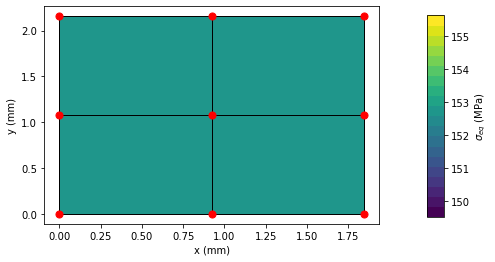

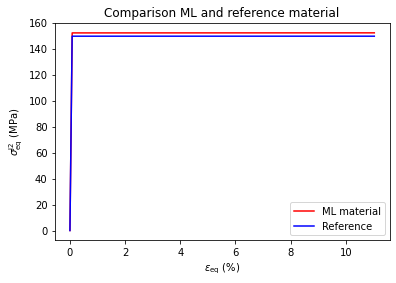

In [5]:
'global parameters for FE model'
eps = 0.1  # total strain for BC
size = 2.
Nel = 2
u1 = -0.78*eps*size
u2 = 0.78*eps*size
'calculate reference data first'
fe=FE.Model(dim=2,planestress=True)
fe.geom([size], LY=size) # define section in absolute length
fe.assign([mat_j2])      # assign material to section
fe.bcleft(0.)            # fix lhs nodes in x-direction
fe.bcbot(0.)             # fix bottom nodes in y-direction
fe.bcright(u1, 'disp')   # define BC in x-direction
fe.bctop(u2, 'disp')     # define BC in y-direction
fe.mesh(NX=Nel, NY=Nel)  # create mesh
fe.solve(verb=False, min_step=5)
sref = fe.sgl
eref = fe.egl
epref = fe.epgl

'Change model to ML material'
fe.u = None # reset solution
fe.assign([mat_ml])      # assign material to section
fe.mesh(NX=Nel, NY=Nel)  # create mesh with new material
fe.solve(verb=False, min_step=5)  # solve for ML material
sml = fe.sgl
eml = fe.egl
epml = fe.epgl
print(fe.lenx, fe.leny)
print('global stresses (MPa)')
print(sml.round(decimals=3))
print('Error:')
print((sml-sref).round(decimals=3))
print('glob. plast. strains (%)')
print((100.*fe.epgl).round(decimals=4))
print('Error:')
print((epml-epref).round(decimals=4))
print('glob. total strains (%)')
print((100.*fe.egl).round(decimals=4))
print('Error:')
print((eml-eref).round(decimals=4))

'plot seq'
fe.plot('seq',mag=1)

'plot stress strain curve'
plt.plot(mat_ml.propJ2['ect']['eeq']*100., mat_ml.propJ2['ect']['seq'], '-r')
plt.plot(mat_j2.propJ2['ect']['eeq']*100., mat_j2.propJ2['ect']['seq'], '-b')
plt.title('Comparison ML and reference material')
plt.xlabel(r'$\epsilon_\mathrm{eq}$ (%)')
plt.ylabel(r'$\sigma^\mathrm{J2}_\mathrm{eq}$ (MPa)')
plt.legend(['ML material', 'Reference'], loc='lower right')
plt.show()



====== Stress-Strain-Curves ======
*** Work hardening rate 1000.0  ***
---------------------------------------------------------
J2 yield stress under uniax-x loading: 150.0 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 150.0 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 150.0 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 150.0 MPa
---------------------------------------------------------


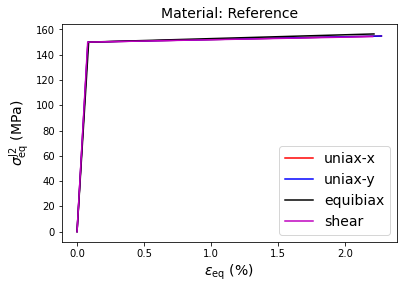

---------------------------------------------------------
J2 yield stress under uniax-x loading: 153.029 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 152.727 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 152.958 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 152.535 MPa
---------------------------------------------------------


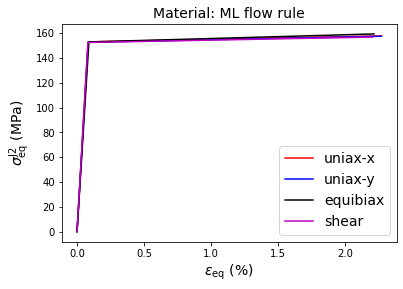


Plot evolution of stresses during plastic deformation for both materials
Hill-material: blue color
ML-material: yellow color


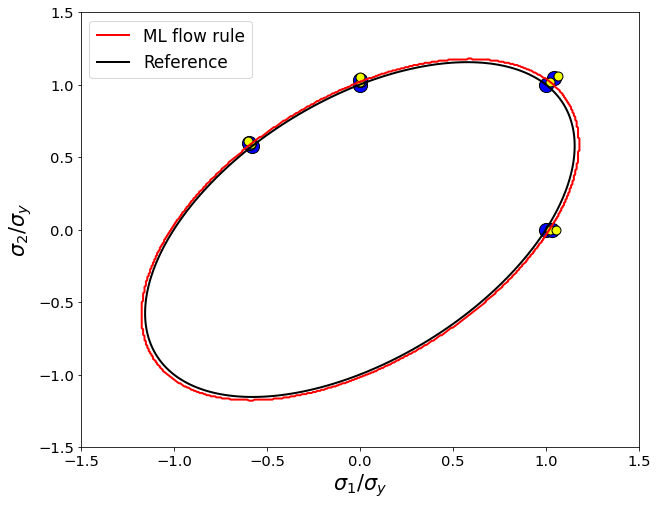

In [6]:
'define work hardening by manipulating material attributes'
'conventionally this would be done by calling the method "Material.plasticity", which would erase the training here'
kh = 1.e3
mat_ml.khard = kh
mat_ml.Hpr = kh/(1.-kh/mat_ml.E)
mat_j2.khard = kh
mat_j2.Hpr = kh/(1.-kh/mat_j2.E)

'Calculate and plot stress strain curves of modified materials'
print('\n\n====== Stress-Strain-Curves ======')
print('*** Work hardening rate',kh,' ***')
mat_j2.calc_properties(eps=0.02, sigeps=True)#, min_step=3)
mat_j2.plot_stress_strain()  #file='sigHill-eps-ref'
mat_ml.calc_properties(verb=False, eps=0.02, sigeps=True)#, min_step=8)
mat_ml.plot_stress_strain() #file='sigJ2-eps-ML')

'plot yield locus'
ax = mat_ml.plot_yield_locus(xstart=-1.5, xend=1.5, ref_mat=mat_j2, field=False, Nmesh=400, fontsize=26)
print('\nPlot evolution of stresses during plastic deformation for both materials')
print('Hill-material: blue color')
print('ML-material: yellow color')
s=80
'Hill material'
stx = mat_j2.sigeps['stx']['sig'][:,0:2]/mat_j2.sy
sty = mat_j2.sigeps['sty']['sig'][:,0:2]/mat_j2.sy
et2 = mat_j2.sigeps['et2']['sig'][:,0:2]/mat_j2.sy
ect = mat_j2.sigeps['ect']['sig'][:,0:2]/mat_j2.sy
ax.scatter(stx[1:,0],stx[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
ax.scatter(sty[1:,0],sty[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
ax.scatter(et2[1:,0],et2[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
ax.scatter(ect[1:,0],ect[1:,1],s=s*2.5, c='#0000ff', edgecolors='k')
'ML material'
stx = mat_ml.sigeps['stx']['sig'][:,0:2]/mat_ml.sy
sty = mat_ml.sigeps['sty']['sig'][:,0:2]/mat_ml.sy
et2 = mat_ml.sigeps['et2']['sig'][:,0:2]/mat_ml.sy
ect = mat_ml.sigeps['ect']['sig'][:,0:2]/mat_ml.sy
ax.scatter(stx[1:,0],stx[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(sty[1:,0],sty[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(et2[1:,0],et2[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(ect[1:,0],ect[1:,1],s=s, c='#f0ff00', edgecolors='k')
#plt.savefig('comp-yield-loci.pdf', format='pdf', dpi=300)

For stronger work hardening rates or larger total strains, the ML flow rule does not converge anymore. Likely, due to the noise in the yield surface.

Isolate pure shear load case, to study the problem more closely.

2.0 2.0
global stresses (MPa)
[[  0.      0.      0.      0.      0.      0.   ]
 [-88.066  88.066   0.      0.      0.     -0.   ]
 [-88.507  88.882   0.      0.      0.      0.   ]
 [-88.949  89.697   0.      0.      0.      0.   ]
 [-89.391  90.513   0.      0.      0.      0.   ]
 [-89.832  91.329   0.      0.      0.      0.   ]]
Reference:
[[  0.      0.      0.      0.      0.      0.   ]
 [-86.603  86.603   0.      0.      0.      0.   ]
 [-89.119  89.119   0.      0.      0.      0.   ]]
glob. plast. strains (%)
[[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [-3.7530e-01  3.7520e-01  1.0000e-04  0.0000e+00  0.0000e+00  0.0000e+00]
 [-7.5040e-01  7.5070e-01 -3.0000e-04  0.0000e+00  0.0000e+00  0.0000e+00]
 [-1.1252e+00  1.1265e+00 -1.3000e-03  0.0000e+00  0.0000e+00  0.0000e+00]
 [-1.4997e+00  1.5025e+00 -2.8000e-03  0.0000e+00  0.0000e+00  0.0000e+00]]
Reference:
[[ 0.      

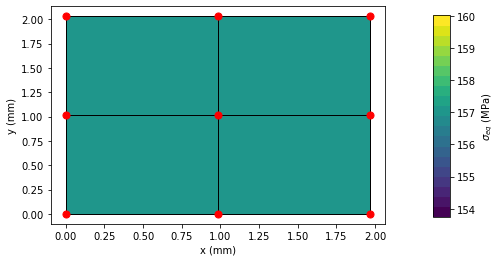

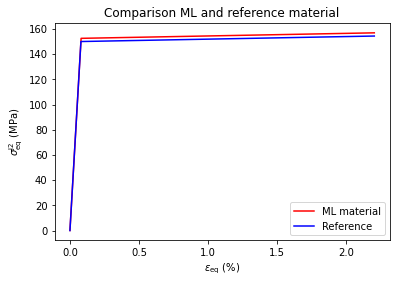

In [7]:
'global parameters for FE model'
eps = 0.02  # total strain for BC
size = 2.
Nel = 2
u1 = -0.78*eps*size
u2 = 0.78*eps*size
'calculate reference data first'
fe=FE.Model(dim=2,planestress=True)
fe.geom([size], LY=size) # define section in absolute length
fe.assign([mat_j2])      # assign material to section
fe.bcleft(0.)            # fix lhs nodes in x-direction
fe.bcbot(0.)             # fix bottom nodes in y-direction
fe.bcright(u1, 'disp')   # define BC in x-direction
fe.bctop(u2, 'disp')     # define BC in y-direction
fe.mesh(NX=Nel, NY=Nel)  # create mesh
fe.solve(verb=False, min_step=None)
sref = fe.sgl
eref = fe.egl
epref = fe.epgl

'New model with ML material'
fe.u = None
fe.assign([mat_ml])      # assign material to section
fe.mesh(NX=Nel, NY=Nel)  # create mesh
fe.solve(verb=False, min_step=5)  # solve for ML material
sml = fe.sgl
eml = fe.egl
epml = fe.epgl
print(fe.lenx, fe.leny)
print('global stresses (MPa)')
print(sml.round(decimals=3))
print('Reference:')
print(sref.round(decimals=3))
print('glob. plast. strains (%)')
print((100.*fe.epgl).round(decimals=4))
print('Reference:')
print((100.*epref).round(decimals=4))

'plot seq'
fe.plot('seq',mag=1)

'plot stress strain curve'
plt.plot(mat_ml.propJ2['ect']['eeq']*100., mat_ml.propJ2['ect']['seq'], '-r')
plt.plot(mat_j2.propJ2['ect']['eeq']*100., mat_j2.propJ2['ect']['seq'], '-b')
plt.title('Comparison ML and reference material')
plt.xlabel(r'$\epsilon_\mathrm{eq}$ (%)')
plt.ylabel(r'$\sigma^\mathrm{J2}_\mathrm{eq}$ (MPa)')
plt.legend(['ML material', 'Reference'], loc='lower right')
plt.show()

With work hardening the stability of the ML material is further deminished.

## Import and process data from micromechanical simulations


*** Microstructure: texture1 ***
41115  data points imported into database  Dataset
Number of load cases:  359
Estimated elasic constants: E=79.92 GPa, nu=0.30
Estimated yield strength: 38.80 MPa, from 2020 data sets with PEEQ approx. 0.002


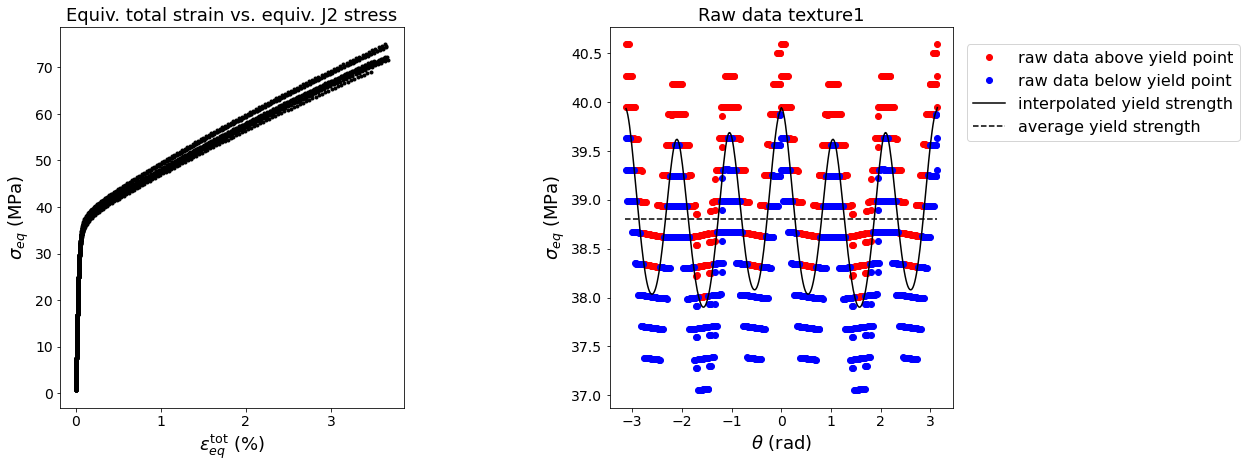

In [8]:
'set path truncs and open JSON file'
path_data='./Data/'
path_json='./Data/JSON/'
msl = ['texture1']

'import data sets for specified texture files and provide graphical output'
data = FE.Data(msl, path_data, path_json, epl_crit=0.002, plot=True) 

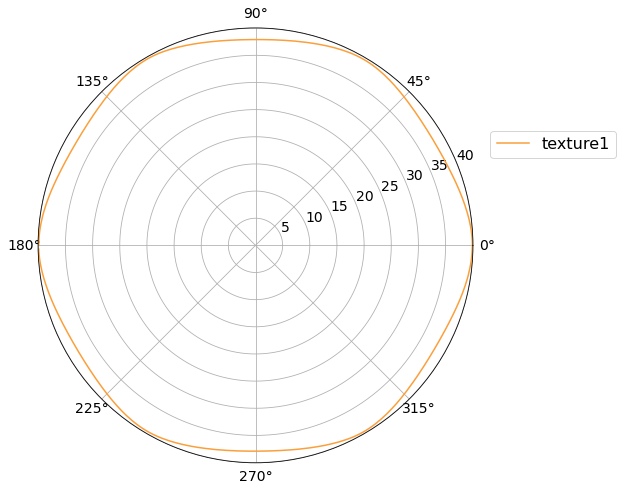

In [9]:
data.plot_yield_locus()


---------------------------

SVM classification training
---------------------------

19386  training data sets created from 1 microstructures
Using cyclindrical stresses for training
SVC(C=15, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=3, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Training data points: 19386 from 1 microstructures
Training set score: 99.63705353460365 %
Plot ML yield loci with reference and test data of each microstructure


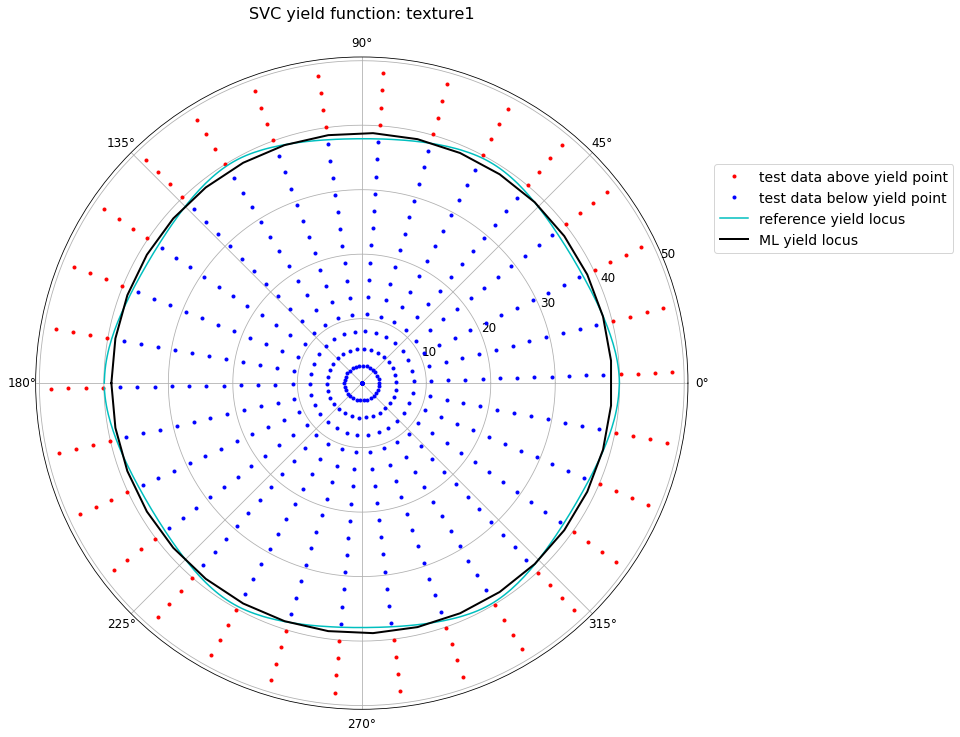

In [10]:
'define material with ML flow rule based on micromechanical data'
mat_d = FE.Material(name='ML-all')  # define material 
mat_d.elasticity(E=data.E_av, nu=data.nu_av)     # assign average properties to material
mat_d.plasticity(sy=data.sy_av)                  # assessed from data
mat_d.microstructure(data, texture=data.texture) # define microstructural parameters for material

'train SVC with data from all microstructures'
mat_d.train_SVC(C=15, gamma=3, plot=True)

ML yield locus and isotropic reference for yield strength 38.8 MPa


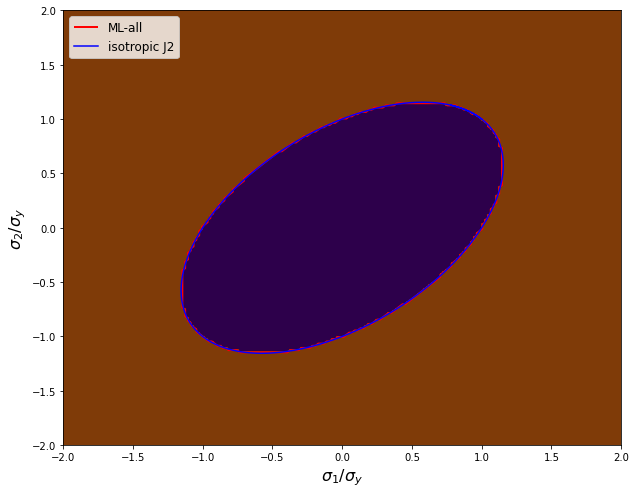

Stress-Strain-Curves
---------------------------------------------------------
J2 yield stress under uniax-x loading: 38.807 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 38.81 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 38.807 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 38.824 MPa
---------------------------------------------------------


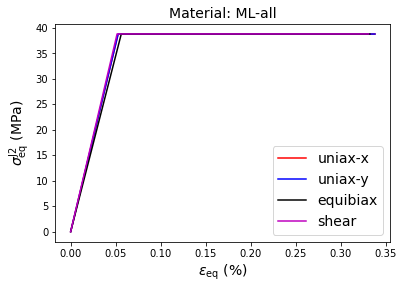

In [11]:
print('ML yield locus and isotropic reference for yield strength', mat_d.sy.round(decimals=2),'MPa')
mat_d.plot_yield_locus(field=True, iso=True, Nmesh=200)
plt.show()
print('Stress-Strain-Curves')
mat_d.calc_properties(verb=False, eps=0.003, sigeps=True)
mat_d.plot_stress_strain()